# Realizando inferência com um modelo pré-treinado através da interface programável do TerraTorch

## **Inferência direta e simples.**

In [1]:
import argparse
import os
from typing import List, Union
import re
import datetime
import numpy as np
import rasterio
import torch
import rioxarray
import yaml
from einops import rearrange
from terratorch.cli_tools import LightningInferenceModel
from terratorch.utils import view_api

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### O diretório em que salvaremos a saída do modelo.

In [2]:
output_dir = "inference_output"

### O caminho para o arquivo de configuração.

In [3]:
config_file = "burn_scars_config.yaml"

### O caminho para o checkpoint local (um arquivo guardando os pesos do modelo).

In [4]:
checkpoint = "checkpoints/Prithvi_EO_V2_300M_BurnScars.pt"

### Caminho para o diretório que contém os arquivos de entrada.

In [5]:
input_dir = "data/examples/"

### Um arquivo para usar como exemplo na inferência de arquivo único. 

In [6]:
example_file = "data/examples/subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4_merged.tif"

### Uma lista contendo as bandas que sabemos estar presentes nos arquivos de entrada.

In [7]:
predict_dataset_bands=[
      "BLUE",
      "GREEN",
      "RED",
      "NIR_NARROW",
      "SWIR_1",
      "SWIR_2",
  ]

### Uma lista com as bandas escolhidas (dentre as mostradas acima) para servirem de entrada para o modelo. Em nosso examplo, usaremos todas. 

In [8]:
predict_output_bands = predict_dataset_bands

### Vamos criar o direório de saída, caso ele não exista. 

In [9]:
os.makedirs(output_dir, exist_ok=True)

In [10]:
with open(config_file, "r") as f:
    config_dict = yaml.safe_load(f)

### Instanciando o modelo a partir dos arquivos e outras informações que temos. 

In [11]:
lightning_model = LightningInferenceModel.from_config(config_file, checkpoint, predict_dataset_bands, predict_output_bands)

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/lightning/pytorch/cli.py:528: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['-f', '/home/jalmeida/.local/share/jupyter/runtime/kernel-0829eb17-16c5-47d7-b650-f5efa5c2622c.json'], args=['--config', 'burn_scars_config_tiled.yaml', '--data.init_args.predict_dataset_bands', '[BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2]', '--data.init_args.predict_output_bands', '[BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2]'].
Seed set to 2
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBa

[<lightning.pytorch.callbacks.early_stopping.EarlyStopping object at 0x7f2963215090>, <lightning.pytorch.callbacks.lr_monitor.LearningRateMonitor object at 0x7f29632171d0>, <terratorch.cli_tools.CustomWriter object at 0x7f296358d850>]


### Realizando inferência para um único arquivo. A saída é um tensor (`torch.Tensor`). 

In [12]:
prediction = lightning_model.inference(example_file)
prediction

You are using a CUDA device ('NVIDIA RTX A4500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])

### Visualizando a imagem de entrada. Do objeto arquivo `fp` selecionaremos apenas as bandas RGB (que correspondem aos índices 2, 1 e 0) para visualização. Note que adicionamos um desvio para o branco na imagem (`fp[[2,1,0]]+0.20`) com o intuito de clareá-la. 

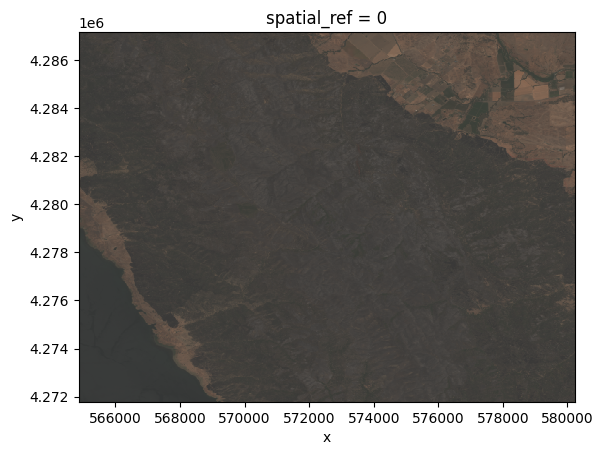

In [41]:
import rioxarray
fp = rioxarray.open_rasterio(example_file)
(fp[[2,1,0]]+0.20).plot.imshow(rgb="band")

### Visualizando a imagem de saída. 

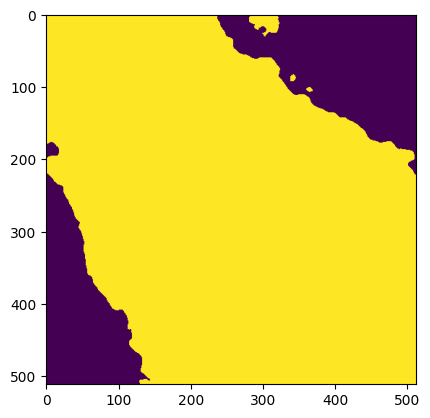

In [17]:
import matplotlib.pyplot as plt
plt.imshow(prediction)

### Podemos também fazer inferência para um diretório contendo um conjunto de imagens usando o seguinte método. 

In [30]:
predictions, file_names = lightning_model.inference_on_dir(input_dir)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


['data/examples/subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4_merged.tif',
 'data/examples/subsetted_512x512_HLS.S30.T10SFF.2018190.v1.4_merged.tif',
 'data/examples/subsetted_512x512_HLS.S30.T10SGF.2020217.v1.4_merged.tif']

### A chamada vai retornar uma lista de predições e outra contendo os nomes dos arquivos de entrada. 

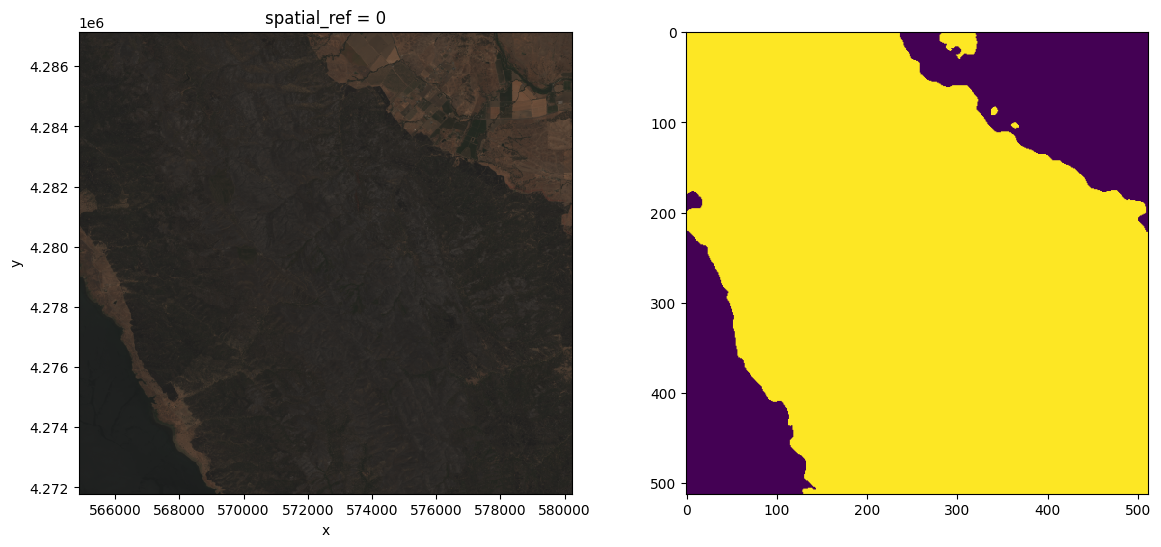

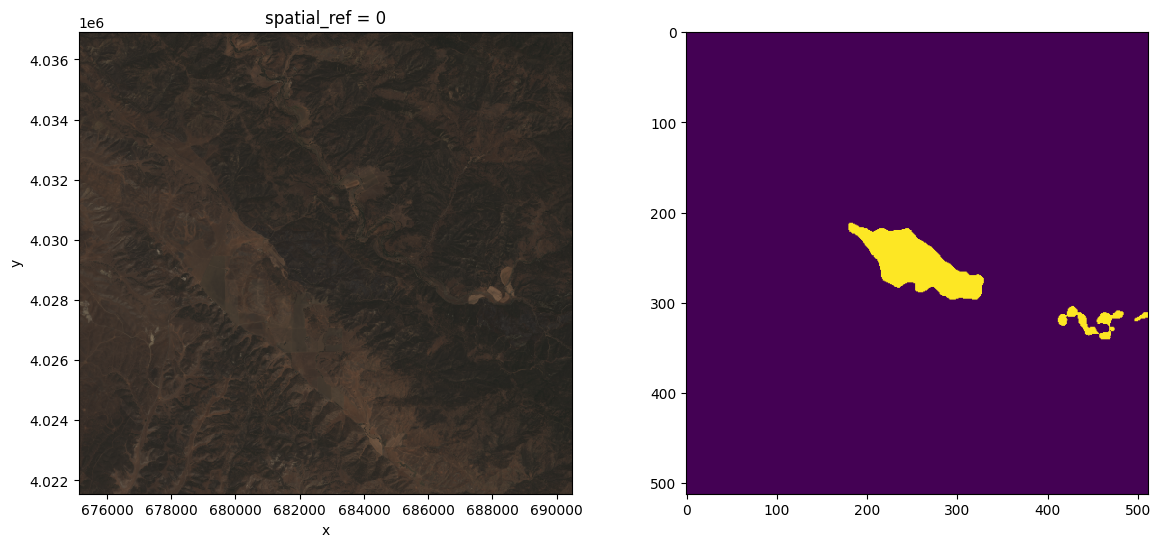

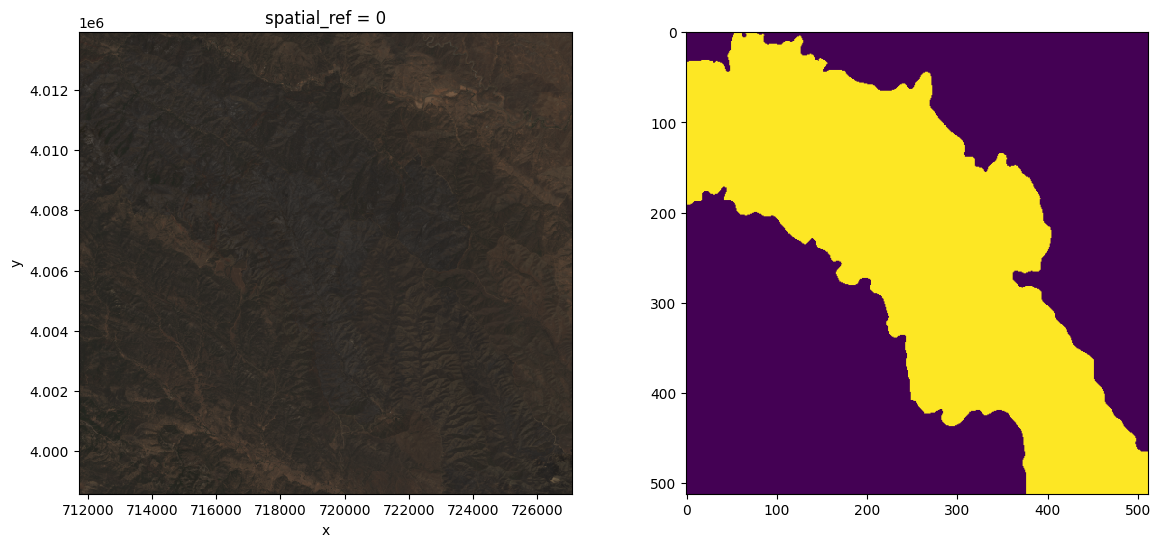

In [40]:
for pred, input_file in zip(predictions, file_names):
    fp = rioxarray.open_rasterio(input_file)
    f, ax = plt.subplots(1,2, figsize=(14,6))
    (fp[[2,1,0]]+0.10).plot.imshow(rgb="band", ax=ax[0])
    ax[1].imshow(pred)

## **Tiled Inference**
### Agora vamos tentar uma forma alternativa de inferência a "inferência particionada" (tiled inference). Esse tipo de inferência é útil quando a GPU (ou a memória RAM associada à CPU, se for o caso) é insuficiente para alocar todas as informações necessárias para executar o modelo (bibliotecas básicas, modelo e dados), pois, ao invés de aplicar o modelo à imagem integral, a divide em pequenos retângulos, cujas dimensões são definidas peelo usuário, aplicada o modleo separadamente e depois reconstrói a figura de saída. Para executar esse tipo de inferência, faremos uso do arquivo abaixo. 

In [42]:
config_file_tiled = "burn_scars_config_tiled.yaml"

### Veja que o seu conteúdo é idêntico ao do outro arquivo YAML, exceto pela adição do subcampo
```
    tiled_inference_parameters:
      h_crop: 128
      h_stride: 64
      w_crop: 128
      w_stride: 64
      average_patches: true

```
### às variáveis recebidas pelo campo `model`. As variáveis com o sufixo `_crop` se referem às dimensões dos "tiles" enquanto que as com `_stride` controlam a distância entre eles, que podem, inclusive, se sobrepor. 

In [43]:
lightning_model = LightningInferenceModel.from_config(config_file_tiled, checkpoint, predict_dataset_bands, predict_output_bands)

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/lightning/pytorch/cli.py:528: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['-f', '/home/jalmeida/.local/share/jupyter/runtime/kernel-0829eb17-16c5-47d7-b650-f5efa5c2622c.json'], args=['--config', 'burn_scars_config_tiled.yaml', '--data.init_args.predict_dataset_bands', '[BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2]', '--data.init_args.predict_output_bands', '[BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2]'].
Seed set to 2
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBa

[<lightning.pytorch.callbacks.early_stopping.EarlyStopping object at 0x7f2949234d10>, <lightning.pytorch.callbacks.lr_monitor.LearningRateMonitor object at 0x7f2949210bd0>, <terratorch.cli_tools.CustomWriter object at 0x7f294958a5d0>]


In [44]:
predictions, file_names = lightning_model.inference_on_dir(input_dir)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


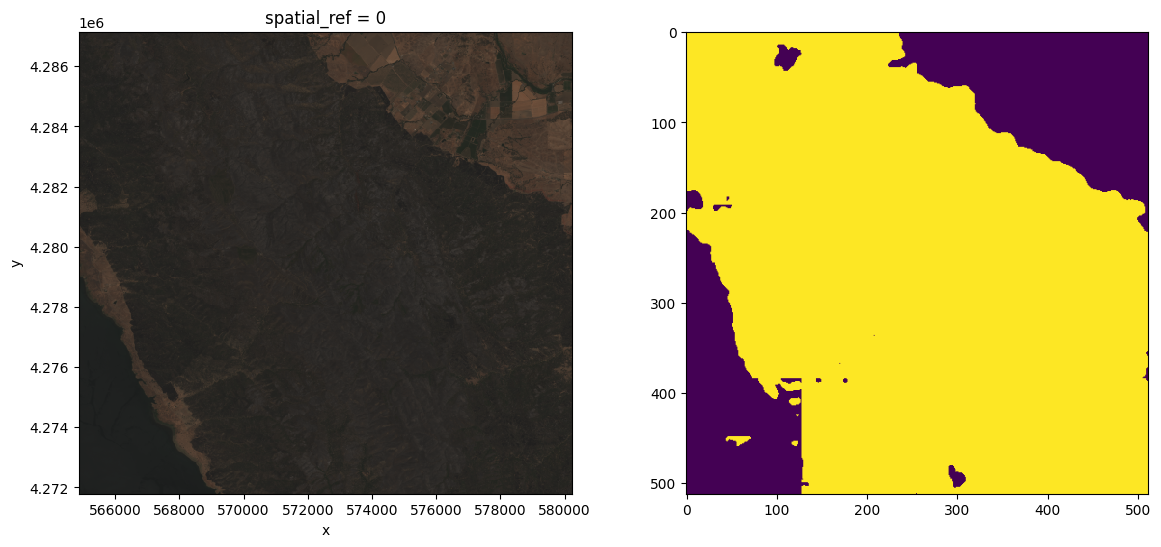

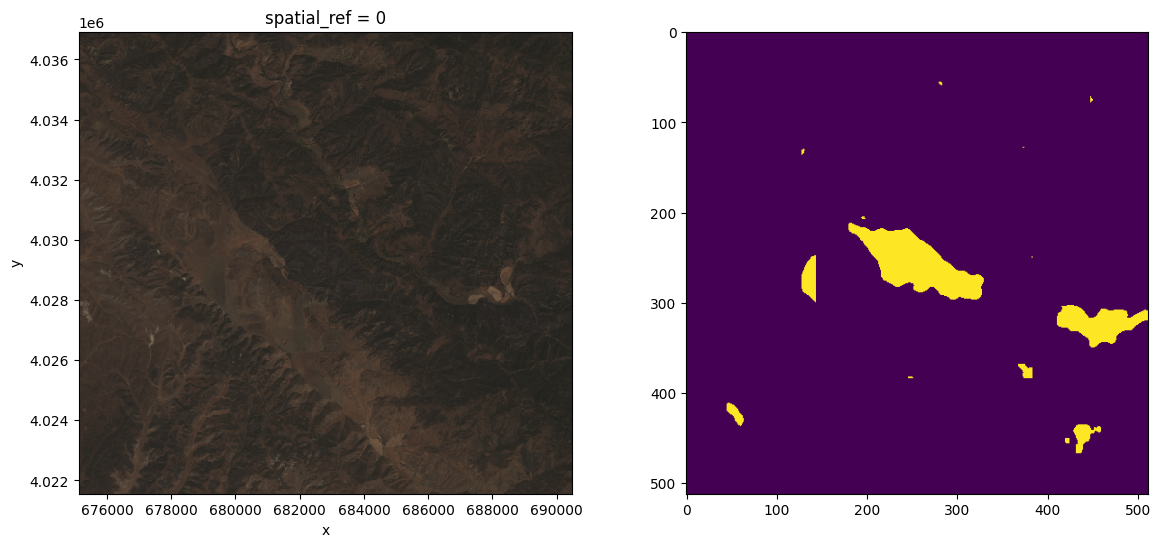

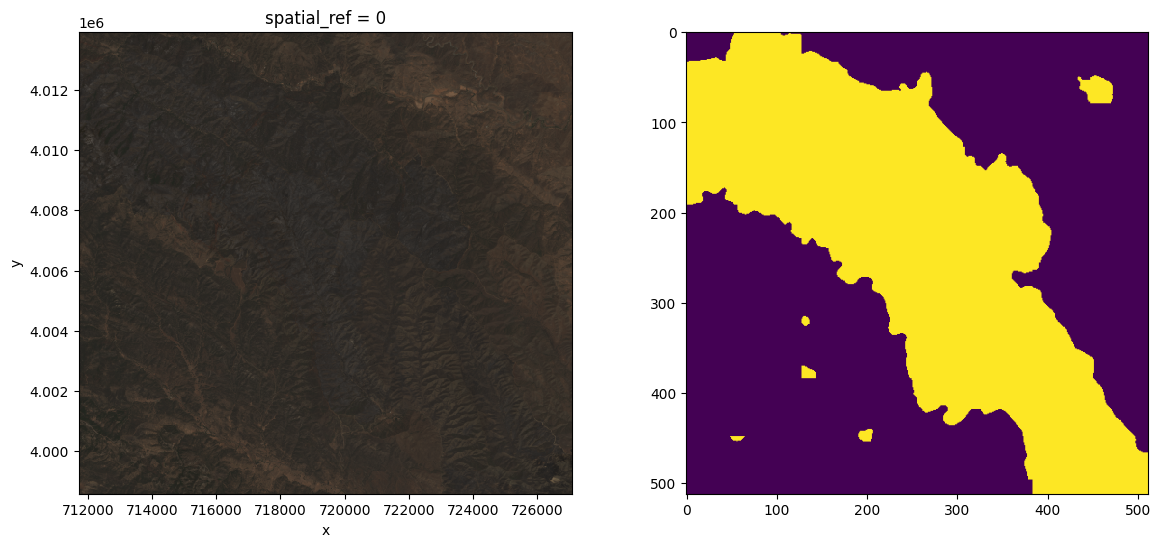

In [45]:
for pred, input_file in zip(predictions, file_names):
    fp = rioxarray.open_rasterio(input_file)
    f, ax = plt.subplots(1,2, figsize=(14,6))
    (fp[[2,1,0]]+0.10).plot.imshow(rgb="band", ax=ax[0])
    ax[1].imshow(pred)